# Capstone- Extension 

### Introduction

In the 1st part of the Capstone project I have created a predictive model that predicts the weekly sales of 45 stores for next 3 months. In the first part I haven't considered the department level data and took the sum of department sales to find the total sales of each store.

In this part of the project I am extending the scope to department Level and trying to predict the sales of all the 98 departments for each store. Since my system couldn't handle this massive amount of data I am selecting the first 5 stores data to implement the same. This is because by selecting the first 5 stores it would be a perfect prototype of the entire data.

In [1]:
# Importing all necessary libraries to proceed with this project.

import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import calendar
from sklearn.cross_validation import cross_val_score, cross_val_predict
# from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso, LinearRegression, LassoCV
# from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neighbors import KNeighborsRegressor
import random
# from itertools import cycle, islice
# from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
# Import timedelta from datetime library
from datetime import timedelta


ss = StandardScaler()
sns.set_style('darkgrid')

/home/mahendra/anaconda2/envs/python3/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
# get the Datas
walmart_path = './datasets/walmart.csv'
data = pd.read_csv(walmart_path)

In [3]:
# Selecting only first 5 stores.
data = data[data.Store <  6]

In [4]:
data.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False


In [5]:
# yes my assumption was correct python have something to do with date format. 
# Now converting "Date" again to date time
data["Date"]=pd.to_datetime(data.Date)

# Extracting details from date given. so that can be used for seasonal checks or grouping

data["Day"]=data.Date.dt.day
data["Month"]=data.Date.dt.month
data["Year"]=data.Date.dt.year

# Changing the Months value from numbers to real values like Jan, Feb to Dec
data['Month'] = data['Month'].apply(lambda x: calendar.month_abbr[x])

In [6]:
data.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Day,Month,Year
0,1,1,2010-02-05,24924.50,False,5,Feb,2010
1,1,1,2010-02-12,46039.49,True,12,Feb,2010
2,1,1,2010-02-19,41595.55,False,19,Feb,2010
3,1,1,2010-02-26,19403.54,False,26,Feb,2010
4,1,1,2010-03-05,21827.90,False,5,Mar,2010


In [7]:
# Will convert the bool to 1 and 0 for easier use later.
data.IsHoliday=data.IsHoliday.map(lambda x: 1 if x==True else 0)

In [8]:
data.Store=data.Store.map(lambda x: 'Store_%s'%x)
data.Dept=data.Dept.map(lambda x: 'Dept_%s'%x)


In [9]:
data.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Day,Month,Year
0,Store_1,Dept_1,2010-02-05,24924.50,0,5,Feb,2010
1,Store_1,Dept_1,2010-02-12,46039.49,1,12,Feb,2010
2,Store_1,Dept_1,2010-02-19,41595.55,0,19,Feb,2010
3,Store_1,Dept_1,2010-02-26,19403.54,0,26,Feb,2010
4,Store_1,Dept_1,2010-03-05,21827.90,0,5,Mar,2010


#### Feature Engineering

Adding a new feature which is a combination of the store and dept. This is because than keeping store and dept individually the combination can explain the data tred better. 

In [10]:
data["Store_Dept"]=data["Store"]+data["Dept"]

In [11]:
data.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Day,Month,Year,New_Feature
0,Store_1,Dept_1,2010-02-05,24924.50,0,5,Feb,2010,Store_1Dept_1
1,Store_1,Dept_1,2010-02-12,46039.49,1,12,Feb,2010,Store_1Dept_1
2,Store_1,Dept_1,2010-02-19,41595.55,0,19,Feb,2010,Store_1Dept_1
3,Store_1,Dept_1,2010-02-26,19403.54,0,26,Feb,2010,Store_1Dept_1
4,Store_1,Dept_1,2010-03-05,21827.90,0,5,Mar,2010,Store_1Dept_1


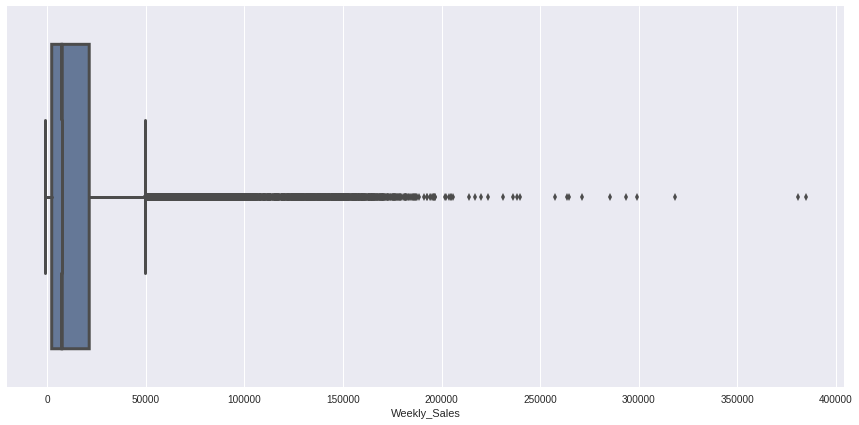

In [12]:
fig = plt.figure(figsize=(15, 7))
ax = fig.gca()

ax = sns.boxplot(data.Weekly_Sales, orient='h', fliersize=5, 
                 linewidth=3, notch=True, saturation=0.5, ax=ax)
plt.show()

In [13]:
# Lets consider 3,000,000 as upper limit 
data=data[(data.Weekly_Sales<40000) & (data.Weekly_Sales>0)]

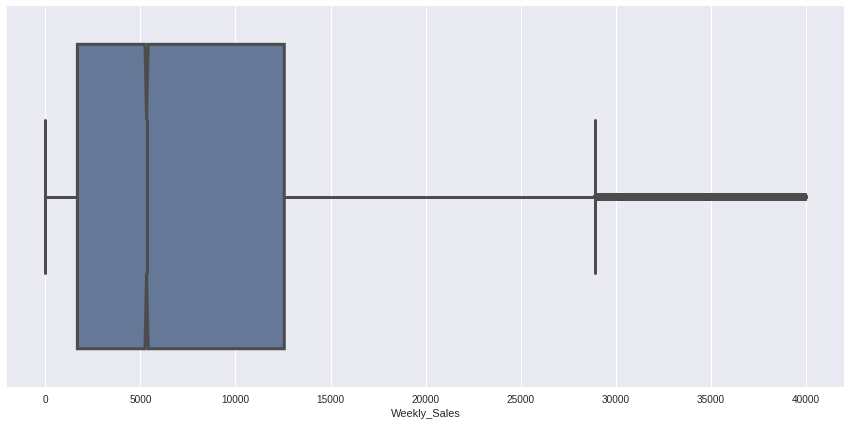

In [14]:
fig = plt.figure(figsize=(15, 7))
ax = fig.gca()

ax = sns.boxplot(data.Weekly_Sales, orient='h', fliersize=5, 
                 linewidth=3, notch=True, saturation=0.5, ax=ax)
plt.show()

In [15]:
data.shape

(41863, 9)

In [16]:
# Create Week column which says which week of the month it is. 
data["Week"]= round(np.floor(((data.Day-1)/7)+1))


In [17]:
data.drop('Day',axis=1,inplace=True)

In [18]:
data.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Month,Year,New_Feature,Week
0,Store_1,Dept_1,2010-02-05,24924.50,0,Feb,2010,Store_1Dept_1,1.0
3,Store_1,Dept_1,2010-02-26,19403.54,0,Feb,2010,Store_1Dept_1,4.0
4,Store_1,Dept_1,2010-03-05,21827.90,0,Mar,2010,Store_1Dept_1,1.0
5,Store_1,Dept_1,2010-03-12,21043.39,0,Mar,2010,Store_1Dept_1,2.0
6,Store_1,Dept_1,2010-03-19,22136.64,0,Mar,2010,Store_1Dept_1,3.0


In [19]:
# Create dummies for the columns that are required for later studies
# Store_dummies = pd.get_dummies(data.Store, prefix='Store')
# Dept_dummies= pd.get_dummies(data.Dept, prefix='Dept')
New_dummies = pd.get_dummies(data.Store_Dept, drop_first=True)
Month_dummies = pd.get_dummies(data.Month, prefix='Month')
Year_dummies = pd.get_dummies(data.Year, prefix='Year')
Week_dummies = pd.get_dummies(data.Week, prefix='Week')

# concatenate DataFrames (axis=0 for rows, axis=1 for columns)
data = pd.concat([data, New_dummies,Month_dummies,Year_dummies,Week_dummies], axis=1)

In [20]:
# Drop the columns that we have created dummies
data.drop(['Dept', 'Store','Month','Year','Week','Store_Dept'], axis=1, inplace=True) 
# drop each column from the list of dummies to make it perfect to use in models
data.drop(['Month_Jan','Year_2010','Week_5.0'], axis=1, inplace=True) 

In [21]:
data = data.reindex(np.random.permutation(data.index))

In [22]:
data.shape

(41863, 361)

In [23]:
data.columns

Index(['Date', 'Weekly_Sales', 'IsHoliday', 'Store_1Dept_10', 'Store_1Dept_11',
       'Store_1Dept_12', 'Store_1Dept_13', 'Store_1Dept_14', 'Store_1Dept_16',
       'Store_1Dept_17',
       ...
       'Month_May', 'Month_Nov', 'Month_Oct', 'Month_Sep', 'Year_2011',
       'Year_2012', 'Week_1.0', 'Week_2.0', 'Week_3.0', 'Week_4.0'],
      dtype='object', length=361)

In [24]:
# data.to_csv('./datasets/data.csv', index = False)

In [25]:
predictors=[col for col in data.columns ]

X=data[predictors]
y=data.Weekly_Sales.values

In [26]:
X.columns

Index(['Date', 'Weekly_Sales', 'IsHoliday', 'Store_1Dept_10', 'Store_1Dept_11',
       'Store_1Dept_12', 'Store_1Dept_13', 'Store_1Dept_14', 'Store_1Dept_16',
       'Store_1Dept_17',
       ...
       'Month_May', 'Month_Nov', 'Month_Oct', 'Month_Sep', 'Year_2011',
       'Year_2012', 'Week_1.0', 'Week_2.0', 'Week_3.0', 'Week_4.0'],
      dtype='object', length=361)

In [27]:
offset = timedelta(days=90)
split_date=X.Date.max()-offset

In [28]:
X_train = X.ix[:,2:][X.Date < split_date]
y_train = X['Weekly_Sales'][X.Date < split_date]

X_test = X.ix[:,2:][X.Date > split_date]
y_test = X['Weekly_Sales'][X.Date > split_date]

# X_train.reset_index(range(0,len(X_train)),inplace=True)
# X_test.reset_index(range(0,len(X_test)),inplace=True)

In [29]:
X_train.columns

Index(['IsHoliday', 'Store_1Dept_10', 'Store_1Dept_11', 'Store_1Dept_12',
       'Store_1Dept_13', 'Store_1Dept_14', 'Store_1Dept_16', 'Store_1Dept_17',
       'Store_1Dept_18', 'Store_1Dept_19',
       ...
       'Month_May', 'Month_Nov', 'Month_Oct', 'Month_Sep', 'Year_2011',
       'Year_2012', 'Week_1.0', 'Week_2.0', 'Week_3.0', 'Week_4.0'],
      dtype='object', length=359)

In [30]:
# Xs = ss.fit_transform(X)
X_train_s=ss.fit_transform(X_train)
X_test_s=ss.fit_transform(X_test)

In [31]:
lasso_cv = LassoCV(n_alphas=1000,max_iter=2000, cv=10, verbose=1)
lasso_cv.fit(X_train_s, y_train)

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

LassoCV(alphas=None, copy_X=True, cv=10, eps=0.001, fit_intercept=True,
    max_iter=2000, n_alphas=1000, n_jobs=1, normalize=False,
    positive=False, precompute='auto', random_state=None,
    selection='cyclic', tol=0.0001, verbose=1)

In [32]:
# Put the features and coefs into a dataframe
# sort by magnitude
lasso_feat = pd.DataFrame(dict(feature=X_train.columns, coef=lasso_cv.coef_, abscoef=np.abs(lasso_cv.coef_)))
lasso_feat.sort_values('abscoef', inplace=True, ascending=False)
# main_features
lasso_feat[lasso_feat.coef != 0.]

,abscoef,coef,feature
30,1173.000921,1173.000921,Store_1Dept_4
4,1130.190207,1130.190207,Store_1Dept_13
57,1129.633527,1129.633527,Store_1Dept_8
66,1106.309513,1106.309513,Store_1Dept_97
123,975.575467,975.575467,Store_2Dept_79
267,973.855353,973.855353,Store_4Dept_97
207,964.843628,964.843628,Store_4Dept_10
70,963.102610,963.102610,Store_2Dept_10
131,949.170122,949.170122,Store_2Dept_96
239,948.709565,948.709565,Store_4Dept_46


** The list of features that are seleted and their magnitude of effect on weekly sales can be seen above**

** We will set the predictors that we got from Lasso as our actual predictors and use in further models**

In [33]:
actual_predictors=lasso_feat[lasso_feat.coef != 0.].feature.values

In [34]:
# Lets see the best alpha score
lasso_cv.alpha_

# best alpha score =1.5021409058295649 which could be used later

1.5021409058295645

In [35]:
# We will assign the best alpha score and according to that we will train and test our model
best_lasso = Lasso(alpha=lasso_cv.alpha_)
best_lasso.fit(X_train_s, y_train)

Lasso(alpha=1.5021409058295645, copy_X=True, fit_intercept=True,
   max_iter=1000, normalize=False, positive=False, precompute=False,
   random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

In [36]:
lasso_scores = cross_val_score(best_lasso, X_train_s, y_train, cv=10)

print (lasso_scores)
print (np.mean(lasso_scores))

[ 0.91499011  0.92032274  0.9015731   0.91906451  0.9072877   0.91823588
  0.91705906  0.90778069  0.91329368  0.90548851]
0.912509598138


** Thats great. getting a cross validated score of 0.913 is good but consider that this is in train data. Now lets use this to predict our last 90 days data which the model don't know about. So if this works well in this test data give a good score and residual is small or comparable to train data we can assume its not overfitting**

In [37]:
lasso_yhat=best_lasso.predict(X_test_s)
lasso_score=best_lasso.score(X_test_s, y_test)
print("R2: ",lasso_score)
lasso_adj_r2 = 1 - (len(y_test)-1)/(len(y_test)-X_test.shape[1]-1)*(1-lasso_score)
print("Adjusted R2: ",lasso_adj_r2)

R2:  0.909070609089
Adjusted R2:  0.899586689467


In [38]:
train_resids = y_train - best_lasso.predict(X_train_s)
test_resids = y_test - lasso_yhat
lasso_residue=np.abs(test_resids).sum()
# Let me look at the actual Residuals.
print("Train Residual",np.abs(train_resids).sum())
print("Test Residual",lasso_residue)
print("Residual ratio of Test to Train",np.abs(test_resids).sum()/np.abs(train_resids).sum())
# The Residual looks quite big. But this can be because our base values ( Weekly Sales) are quite big 
# and in terms of millions

Train Residual 60962211.3656
Test Residual 6682898.72555
Residual ratio of Test to Train 0.109623627094


The residuals seems to be in same ratio,Train dataset have a higher ratio because its compartively bigger in size. 


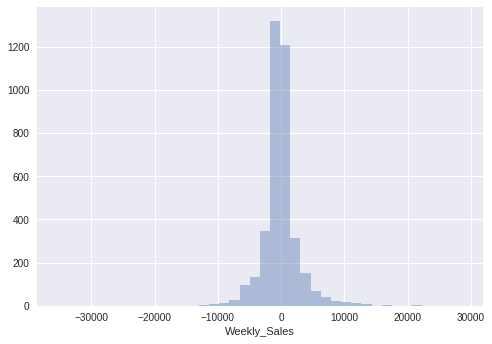

In [39]:
sns.distplot(test_resids, kde=False, bins=40)
plt.show()

# The residuals looks ok and almost like a normal distribution

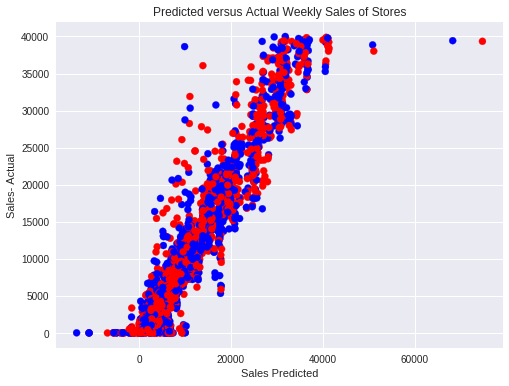

In [40]:
fig = plt.subplots(figsize=(8,6))
plt.scatter(lasso_yhat,y_test,c=['b','r'])
plt.xlabel('Sales Predicted')
plt.ylabel('Sales- Actual')
plt.title('Predicted versus Actual Weekly Sales of Stores')
plt.savefig('/media/mahendra/GA/capstone_walmart/images/Actual_vs_Predicted_Sales.png')
plt.show()